# Đọc file CSV

 **File dữ liệu chưa chuẩn hóa**

In [ ]:
from IPython.display import display
import pandas as pd
data = pd.read_csv('./data_pre.csv')
display(data.head(5))

,Time,Location,MaxTemperature,AvgTemperature,MinTemperature,MaxDewPoint,AvgDewPoint,MinDewPoint,MaxHumidity,AvgHumidity,MinHumidity,MaxWindspeed,AvgWindspeed,MinWindspeed
0,2021-1-1,HoChiMinh,30.0,25.2,23.0,17.0,16.2,16.0,65,57.2,45,12,7.3,5
1,2021-1-2,HoChiMinh,31.0,25.8,22.0,19.0,17.2,16.0,73,59.5,45,12,6.5,2
2,2021-1-3,HoChiMinh,32.0,26.9,22.0,23.0,19.9,17.0,83,67.0,46,7,4.1,0
3,2021-1-4,HoChiMinh,33.0,27.8,24.0,25.0,21.2,18.0,94,70.0,41,10,4.6,1
4,2021-1-5,HoChiMinh,32.0,27.6,24.0,25.0,21.9,19.0,89,72.3,46,9,4.0,1


**File chuẩn hoá dữ liệu**


In [ ]:
df_normal = pd.read_csv('./DataNormal_Maxtemp.csv')
display(df_normal)

,MaxTemperature,AvgTemperature,MinTemperature
0,0.272727,0.208791,0.454545
1,0.363636,0.274725,0.363636
2,0.454545,0.395604,0.363636
3,0.545455,0.494505,0.545455
4,0.454545,0.472527,0.545455
...,...,...,...
876,0.454545,0.351648,0.454545
877,0.454545,0.483516,0.636364
878,0.636364,0.615385,0.818182
879,0.636364,0.670330,0.727273


# Sử dụng mô hình LSTM cho dự đoán nhiệt độ cao nhất trong tương lai

## Xây dựng và huấn luyện mô hình

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Chọn biến
features = ['MaxTemperature','AvgTemperature','MinTemperature']
data_features = df_normal[features].values

# Chọn window
window_size = 7
X_train, y_train = [], []

for i in range(len(data_features) - window_size):
    X_train.append(data_features[i:i + window_size])
    y_train.append(data_features[i + window_size])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape dữ liệu cho mô hình LSTM
X_train = X_train.reshape((X_train.shape[0], window_size, X_train.shape[2]))

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(24))
model.add(Dense(len(features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            67584     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 118,627
Trainable params: 118,627
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
28/28 [==============================] - 12s 11ms/step - loss: 0.0587
Epoch 2/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0156
Epoch 3/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0149
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0147
Epoch 5/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0146
Epoch 6/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 7/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 8/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0138
Epoch 9/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 10/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0137
Epoch 11/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 12/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0135
Epoch 13/100
28/28 [============

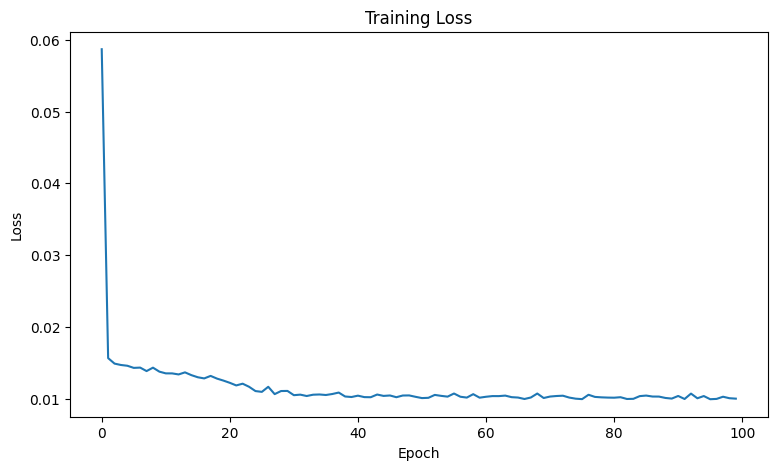

In [ ]:
# Vẽ biểu đồ
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Dự đoán nhiệt độ các ngày tiếp theo

In [ ]:
last_sequence = X_train[-1]

In [ ]:
# Lấy dữ liệu cuối cùng trong tập dữ liệu huấn luyện để dự đoán ngày tiếp theo
last_sequence = X_train[-1]
predicted_temperatures = []

for _ in range(30):
    prediction = model.predict(last_sequence.reshape(1, window_size, len(features)))  # Dự đoán nhiệt độ cao nhất
    predicted_temperature = prediction[0][0]
    predicted_temperatures.append(predicted_temperature)

    # Cập nhật chuỗi dữ liệu cuối cùng để dự đoán ngày tiếp theo
    last_sequence = np.roll(last_sequence, -1, axis=0)  # Đẩy các giá trị sang trái

    last_sequence[-1] = predicted_temperature
    print(last_sequence)

print("Predicted Max Temperatures for the Next 30 Days:", predicted_temperatures)

1/1 [==============================] - 1s 640ms/step
[[0.72727273 0.74725275 0.90909091]
 [0.54545455 0.54945055 0.72727273]
 [0.45454545 0.35164835 0.45454545]
 [0.45454545 0.48351648 0.63636364]
 [0.63636364 0.61538462 0.81818182]
 [0.63636364 0.67032967 0.72727273]
 [0.65229189 0.65229189 0.65229189]]
1/1 [==============================] - 0s 18ms/step
[[0.54545455 0.54945055 0.72727273]
 [0.45454545 0.35164835 0.45454545]
 [0.45454545 0.48351648 0.63636364]
 [0.63636364 0.61538462 0.81818182]
 [0.63636364 0.67032967 0.72727273]
 [0.65229189 0.65229189 0.65229189]
 [0.65704542 0.65704542 0.65704542]]
1/1 [==============================] - 0s 18ms/step
[[0.45454545 0.35164835 0.45454545]
 [0.45454545 0.48351648 0.63636364]
 [0.63636364 0.61538462 0.81818182]
 [0.63636364 0.67032967 0.72727273]
 [0.65229189 0.65229189 0.65229189]
 [0.65704542 0.65704542 0.65704542]
 [0.67388541 0.67388541 0.67388541]]
1/1 [==============================] - 0s 18ms/step
[[0.45454545 0.48351648 0.636363

In [ ]:
# Đảo chuẩn hóa kết quả dự đoán trở lại thành đơn vị thực tế
import sklearn
convert = sklearn.preprocessing.MinMaxScaler()
data_maxtemp = data['MaxTemperature'].values.reshape(-1,1)
convert.fit_transform(data_maxtemp)

predicted_temperatures = np.array(predicted_temperatures).reshape(-1, 1)
predicted = convert.inverse_transform(predicted_temperatures)
predicted

array([[34.17521 ],
       [34.2275  ],
       [34.41274 ],
       [34.56891 ],
       [34.63667 ],
       [34.727303],
       [34.822464],
       [34.939697],
       [35.03939 ],
       [35.12802 ],
       [35.211742],
       [35.294544],
       [35.375065],
       [35.451614],
       [35.52515 ],
       [35.596348],
       [35.665478],
       [35.732456],
       [35.797497],
       [35.860878],
       [35.9228  ],
       [35.98336 ],
       [36.042698],
       [36.100967],
       [36.158306],
       [36.21483 ],
       [36.270653],
       [36.32589 ],
       [36.38065 ],
       [36.435043]], dtype=float32)

In [ ]:
# Lưu file
df = pd.DataFrame({
    'FutureMaxTemp': predicted.flatten(),
})

# Lưu DataFrame vào tệp
df.to_csv('FutureMaxTemp.csv', index=False)
print("Đã lưu dữ liệu vào file FutureMaxTemp.csv")

Đã lưu dữ liệu vào file FutureMaxTemp.csv
